In [1]:
import json
from pathlib import Path

import marimo as mo
from openai.types.chat.chat_completion_tool_param import ChatCompletionToolParam
from openai.types.responses import (
    EasyInputMessageParam,
    ResponseFunctionToolCallParam,
)
from openai.types.responses.function_tool_param import FunctionToolParam
from openai.types.responses.response_input_param import FunctionCallOutput

from eval_recipes.evaluations.claim_verification.claim_verifier import (
    ClaimVerifier,
    InputClaimVerifier,
    InputContext,
    OutputClaimVerifier,
)
from eval_recipes.schemas import ClaimVerifierConfig
from eval_recipes.utils.llm import create_client

# Claim Verification

One of the key challenges with chat assistants built with LLMs is that they sometimes produce content that is inaccurate with respect to the input context, referred to as a "closed-domain hallucination". This evaluation implements a workflow aimed to rigorously verify facts, or claims, whilst not penalizing circumstances where the correct intent is to synthesize new content. Previous approaches do not consider this nuanced view of verifying text generated by LLMs, particularly in a chat context, leading to evaluations that over index on making the response strictly match the source text.

This evaluation is based on the following two papers: [Claimify](https://arxiv.org/abs/2502.10855) and [VeriTrail](https://arxiv.org/abs/2505.21786). It is not an official implementation of either and please cite the original papers if you use this evaluation in your work.

Below is a diagram explaining how this evaluation works.

Html()
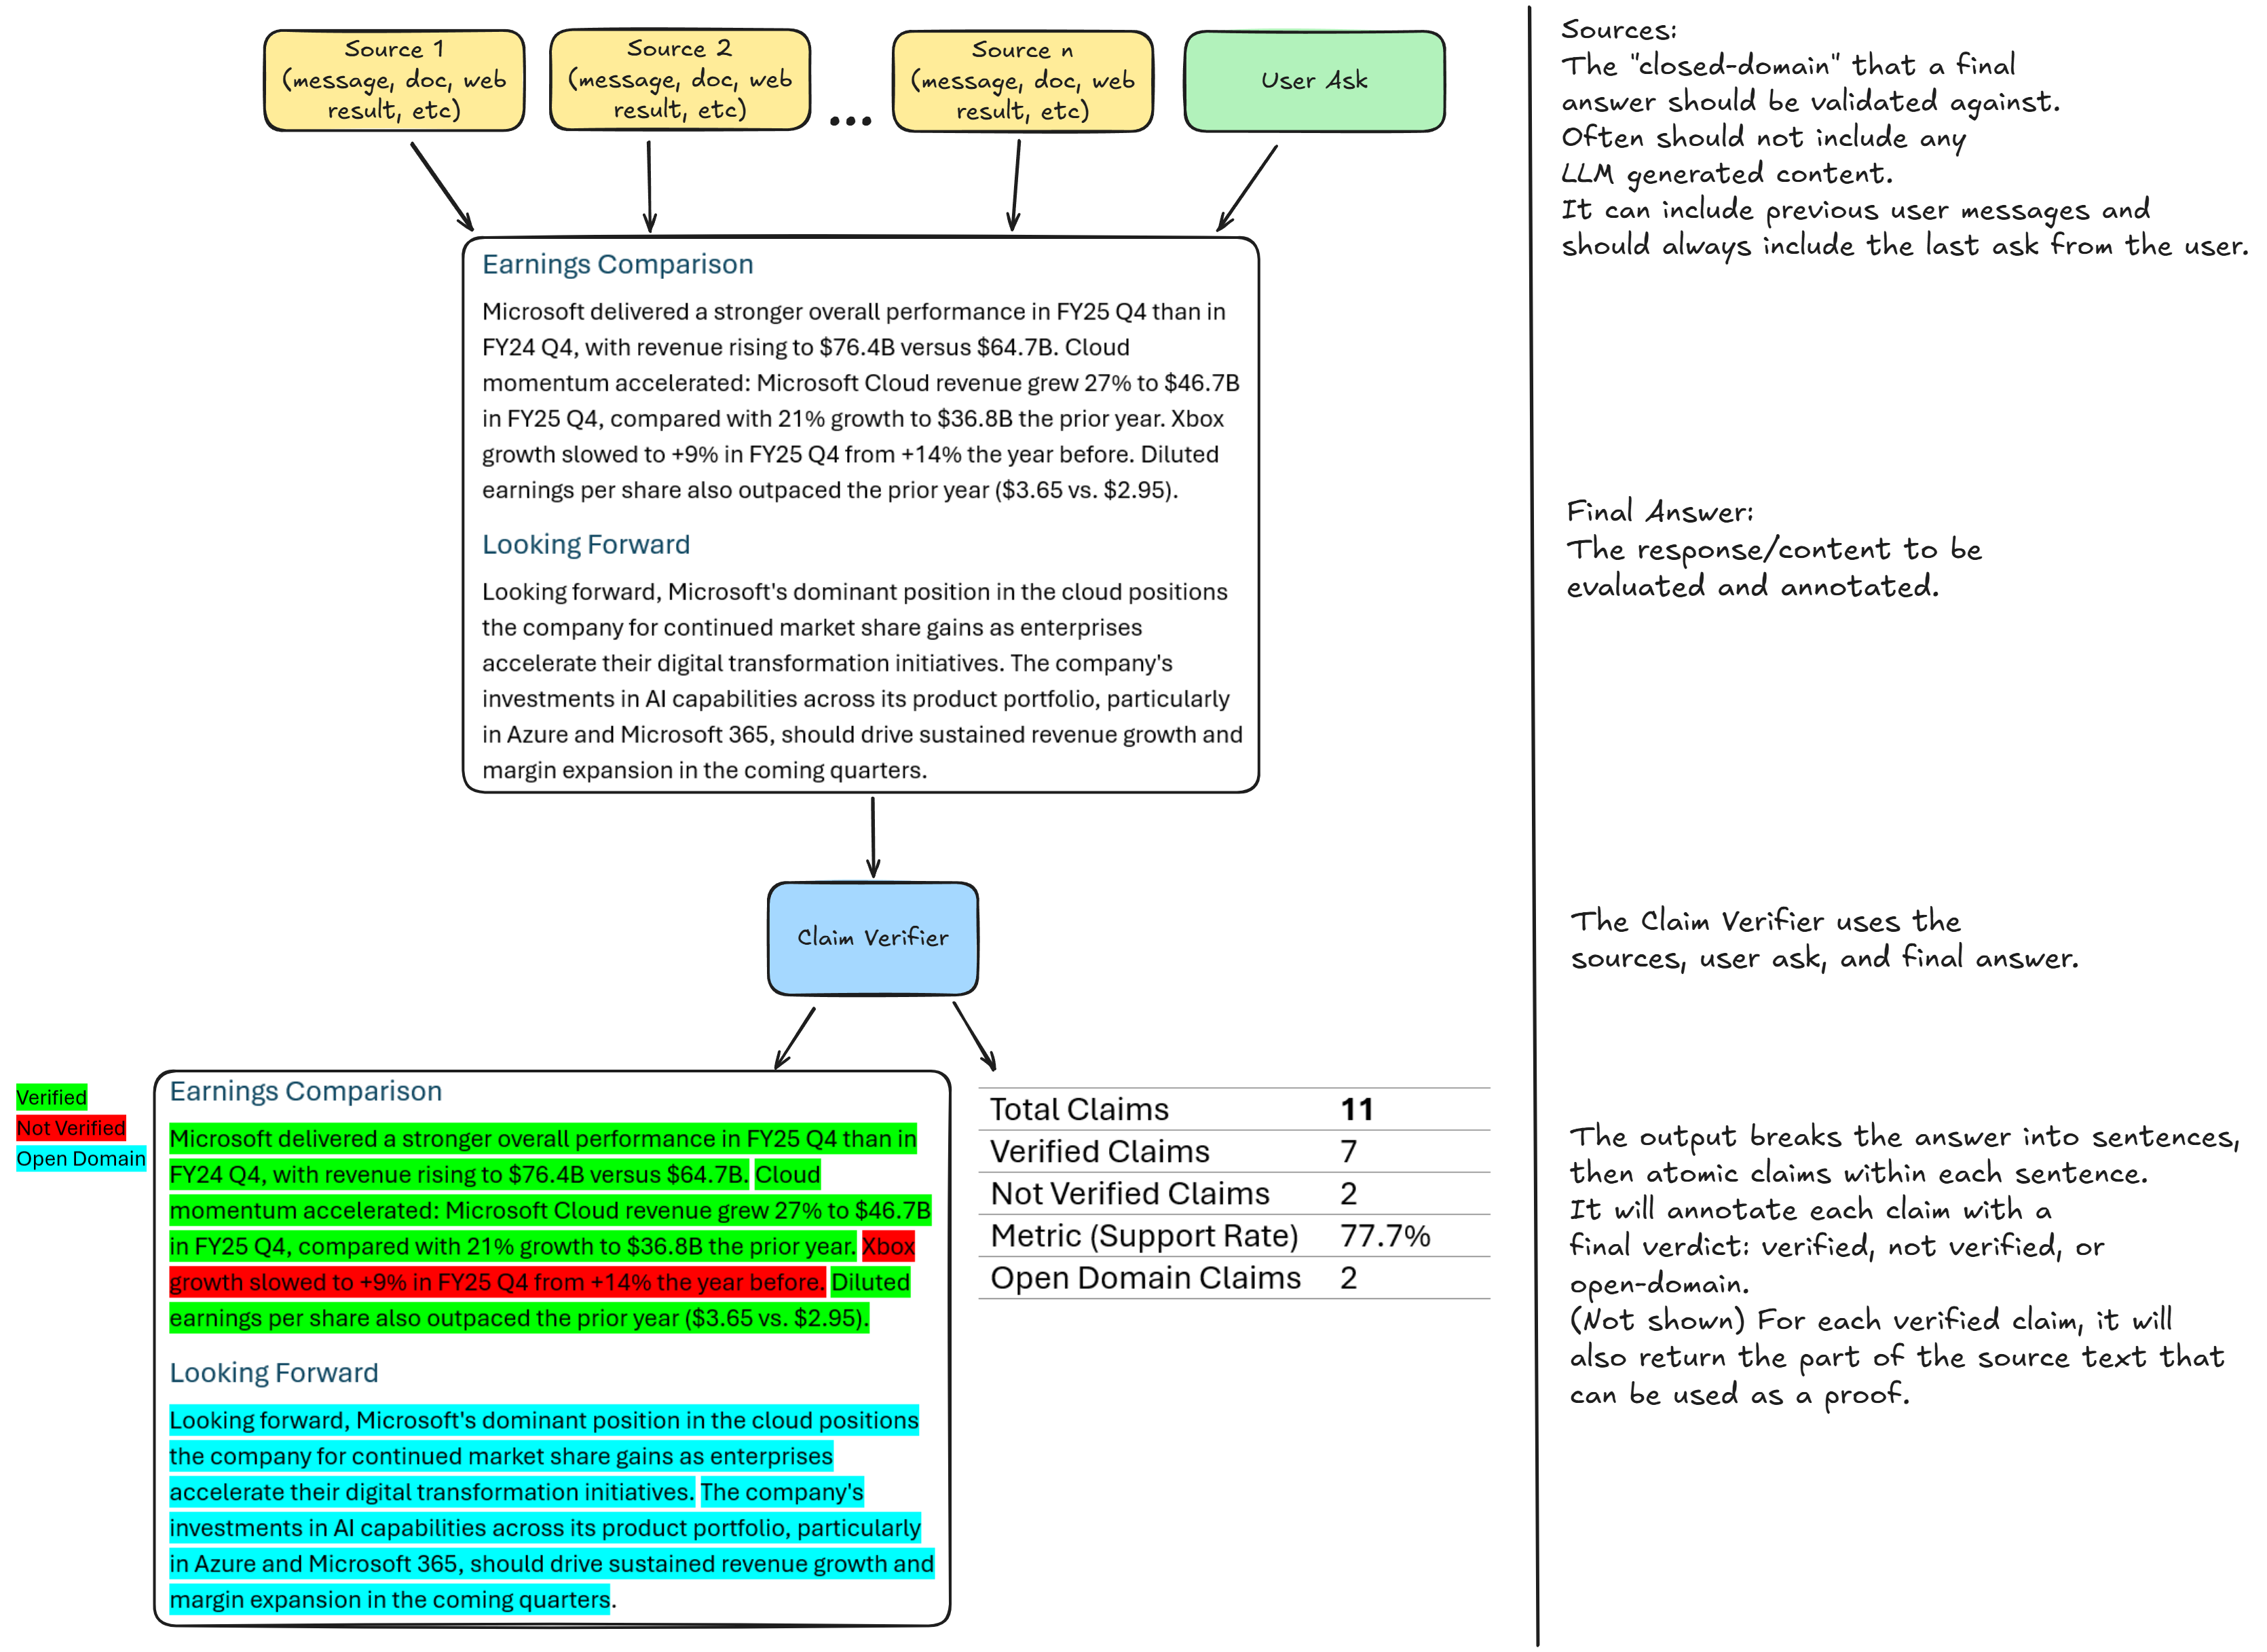

In [2]:
# Handle both .py and .ipynb environments
try:
    # In marimo environment, __file__ is available
    __file__
    image_path = "demos/data/claim diagram.png"
except NameError:
    # Fallback for Jupyter notebooks - use path relative to current directory
    image_path = "data/claim diagram.png"

mo.image(image_path)

# Claim Verification in Action

## Sample Scenario

The running example simulates an interaction with a user and assistant where:

1. User uploads a financial document and the assistant does some initial analysis
2. User uploads another financial document and asks for a comparison written to a document.
3. The assistant has to load in the new file and then use the edit file tool to create the document.

In the generated document, we intentionally insert a factual inaccuracy: it incorrectly states "Xbox growth slowed to +9%" when the source document actually says "More Personal Computing growth slowed to +9%". The claim verification system detects this inaccuracy and helps correct it.

In [3]:
model_chooser_text = mo.md("## Choose the model and reasoning efforts to experiment with the compute/quality tradeoff")

claim_extraction_model = mo.ui.dropdown(
    options=["gpt-5", "gpt-5-mini", "gpt-5-nano"],
    value="gpt-5",
    label="Claim Extraction Model: ",
)
verification_model = mo.ui.dropdown(
    options=["gpt-5", "gpt-5-mini", "gpt-5-nano"],
    value="gpt-5",
    label="Verification Model: ",
)
verification_reasoning_effort = mo.ui.dropdown(
    options=["minimal", "low", "medium", "high"],
    value="medium",
    label="Verification Reasoning Effort: ",
)

mo.vstack(
    [
        model_chooser_text,
        claim_extraction_model,
        verification_model,
        verification_reasoning_effort,
    ]
)

Html()

In [4]:
SYSTEM_PROMPT = """You are an autonomous agent that helps users get their work done. \
You will be provided a set of tools that you should use to gather context and take actions appropriately according to the user's intent. \
You will be provided memories from previous interactions with the user which you should abide by, unless within the context of this conversation it is not appropriate.

<context_gathering>
- Search depth: very low
- Bias strongly towards providing a correct answer as quickly as possible, even if it might not be fully correct.
- Usually, this means an absolute maximum of 2 tool calls.
- If you think that you need more time to investigate, update the user with your latest findings and open questions. You can proceed if the user confirms.
</context_gathering>

<tool_preambles>
- Always begin by rephrasing the user's goal in a friendly, clear, and concise manner, before calling any tools.
- Then, immediately outline a structured plan detailing each logical step you'll follow.
- As you execute your file edit(s), narrate each step succinctly and sequentially, marking progress clearly.
- Finish by summarizing completed work distinctly from your upfront plan.
</tool_preambles>

<memories>
- The user prefers responses in paragraph form
</memories>"""

CAPABILITY_MANIFEST = """# Overview
This assistant can work with files available to it, create or edit documents, read file contents, and search for information using the provided tools. \
Its capabilities are limited to what the tools explicitly support and the ability to return textual answers using Markdown syntax

## File Operations

CAN
- Use ls to list the files that you can view.
- Use view to read the contents of a file at the specified path.
- Use edit_file to create or edit documents.
- Extract and summarize information from files it can read (for example, key metrics in an earnings release).

CANNOT
- Access or read files that are not listed by ls or otherwise not within the accessible file scope.
- Delete, move, rename, or copy files or folders (no tool is provided for these operations).
- Execute or run files, scripts, or programs (no execution tools are provided).
- Guarantee readability of non-text or unsupported formats; if view cannot return readable contents (e.g., binary or protected files), the assistant cannot process them.
- Access external storage locations (e.g., cloud drives, email attachments) unless their files are present in the accessible file list.

## Data Processing

CAN
- Read and interpret text returned by view.
- Identify, extract, and summarize key metrics and facts present in a document (e.g., revenue, EPS, guidance) when they are explicitly stated in the text.
- Perform straightforward comparisons and simple calculations based on the text it can read.

CANNOT
- Infer or fabricate data that is not present in the viewed content or user-provided context.
- Parse or analyze content that is not retrievable as readable text via view.
- Perform code execution, data transformation, or advanced analytics beyond text-based reasoning and summarization (no computation or execution tools are provided).

## Search and External Information

CAN
- Use search to search for information.

CANNOT
- Browse specific URLs, click links, or navigate web pages (no browsing or fetching tool is provided).
- Download external files or ingest web content directly into the file workspace.
- Access real-time or paywalled data sources beyond what search returns via its own interface.

## Writing and Reporting

CAN
- Generate textual summaries, key takeaways, and bullet lists.
- Use edit_file to create or edit documents containing extracted metrics, summaries, notes, or reports.

CANNOT
- Produce or export files in formats or locations not supported by edit_file.
- Guarantee specific document layouts or complex formatting beyond what edit_file supports.

## Interaction and Task Flow

CAN
- Ask for clarification or a file path if the target document (e.g., an earnings release) is not identifiable via ls.
- Propose a plan: use ls to discover candidate files, view to inspect contents, then summarize key metrics, and optionally use edit_file to produce a written report.

CANNOT
- Proceed with file analysis if the needed file is not accessible via ls/view.
- Confirm the existence of a file without checking via ls or receiving the exact path from the user.

## Constraints and Assumptions

- Tool capabilities are limited to their explicit definitions:
    - search: Search for information
    - edit_file: Create or edit documents
    - ls: List the files that you can view
    - view: Read the contents of a file at the specified path
- The assistant's ability to analyze any document depends on successful retrieval of readable content via view.
- Absence of tools for deletion, movement, renaming, code execution, web browsing, downloading, or uploading implies those actions are not supported.
"""

SEARCH_TOOL = ChatCompletionToolParam(
    type="function",
    function={
        "name": "search",
        "description": "Search for information",
        "parameters": {
            "type": "object",
            "properties": {"query": {"type": "string"}},
            "required": ["query"],
        },
    },
)

EDIT_TOOL = ChatCompletionToolParam(
    type="function",
    function={
        "name": "edit_file",
        "description": "Create or edit documents",
        "parameters": {
            "type": "object",
            "properties": {
                "path": {"type": "string"},
                "content": {"type": "string"},
            },
            "required": ["path", "content"],
        },
    },
)

LS_TOOL = ChatCompletionToolParam(
    type="function",
    function={
        "name": "ls",
        "description": "List the files that you can view",
        "parameters": {
            "type": "object",
            "properties": {
                "path": {
                    "type": "string",
                    "description": "relative path to the root",
                }
            },
            "required": ["path"],
        },
    },
)

VIEW_TOOL = ChatCompletionToolParam(
    type="function",
    function={
        "name": "view",
        "description": "Read the contents of a file at the specified path",
        "parameters": {
            "type": "object",
            "properties": {
                "path": {
                    "type": "string",
                    "description": "The path to the file to read (e.g., '/docs/file.txt')",
                }
            },
            "required": ["path"],
        },
    },
)

USER_MESSAGE_1 = "Can you load the earnings release file and tell me the key metrics?"

ASSISTANT_MESSAGE_1 = """You're asking me to load your earnings release file and extract the key metrics. \
My plan is to first locate the earnings release file in your workspace, then open it to identify and summarize key metrics like revenue, EPS, guidance, segment performance, and any notable YoY/QoQ changes. \
I will start by listing the directories to find the file, then open the most likely match, and finally present a concise summary of the metrics."

"Step 1: I will list the top-level directories to locate the earnings release file."""

FUNCTION_CALL_1 = ResponseFunctionToolCallParam(
    {
        "type": "function_call",
        "call_id": "call_1",
        "name": "ls",
        "arguments": "{'path': '/'}",
    }
)

FUNCTION_CALL_OUTPUT_1 = FunctionCallOutput(
    {
        "type": "function_call_output",
        "call_id": "call_1",
        "output": "{'files': ['Earnings Release FY24 Q4.md']}",
    }
)

FUNCTION_CALL_2 = ResponseFunctionToolCallParam(
    {
        "type": "function_call",
        "call_id": "call_2",
        "name": "view",
        "arguments": "{'path': 'Earnings Release FY24 Q4.md'}",
    }
)

# Handle both .py and .ipynb environments
import sys

try:
    data_path_1 = Path(__file__).parents[0] / "data" / "Earnings Release FY24 Q4.md"
    data_path_2 = Path(__file__).parents[0] / "data" / "Earnings Release FY25 Q4.md"
except NameError:
    # Fallback for Jupyter notebooks - use current working directory
    data_path_1 = Path.cwd() / "data" / "Earnings Release FY24 Q4.md"
    data_path_2 = Path.cwd() / "data" / "Earnings Release FY25 Q4.md"

FILE_CONTENT_1 = data_path_1.read_text()
FILE_CONTENT_2 = data_path_2.read_text()

FUNCTION_CALL_OUTPUT_2 = FunctionCallOutput(
    {
        "type": "function_call_output",
        "call_id": "call_2",
        "output": json.dumps({"file_content": FILE_CONTENT_1}),
    }
)

# Net income was intentionally made to be 15B instead of 22B
ASSISTANT_MESSAGE_2 = """Here are the key metrics from the FY24 Q4 earnings release:
- Quarterly Revenue: $64.7B, up 15%
- Operating Income: $27.9B, up 15%
- Net Income: $15.0B, up 10%
- Diluted EPS: $2.95, up 10%"""

USER_MESSAGE_2 = """I added the FY25 Q4 earnings release.
Can you create a document that compares the two quarters and provides a brief analysis?"""

ASSISTANT_MESSAGE_3 = """I'll help you compare the FY24 Q4 and FY25 Q4 earnings releases. \
Let me first locate and read the FY25 Q4 earnings release, then create a comparison document analyzing both quarters' performance.

Step 1: I'll list the files again to find the FY25 Q4 earnings release."""

FUNCTION_CALL_3 = ResponseFunctionToolCallParam(
    {
        "type": "function_call",
        "call_id": "call_3",
        "name": "ls",
        "arguments": "{'path': '/'}",
    }
)

FUNCTION_CALL_OUTPUT_3 = FunctionCallOutput(
    {
        "type": "function_call_output",
        "call_id": "call_3",
        "output": "{'files': ['Earnings Release FY24 Q4.md', 'Earnings Release FY25 Q4.md']}",
    }
)

FUNCTION_CALL_4 = ResponseFunctionToolCallParam(
    {
        "type": "function_call",
        "call_id": "call_4",
        "name": "view",
        "arguments": "{'path': 'Earnings Release FY25 Q4.md'}",
    }
)

FUNCTION_CALL_OUTPUT_4 = FunctionCallOutput(
    {
        "type": "function_call_output",
        "call_id": "call_4",
        "output": json.dumps({"file_content": FILE_CONTENT_2}),
    }
)

FUNCTION_CALL_5 = ResponseFunctionToolCallParam(
    {
        "type": "function_call",
        "call_id": "call_5",
        "name": "edit_file",
        "arguments": json.dumps(
            {
                "path": "Earnings_Comparison.md",
                "content": """# Earnings Comparison
Comparing the two quarters, Microsoft delivered a stronger overall performance in FY25 Q4 than in FY24 Q4, with revenue rising to $76.4B versus $64.7B, supported by even sharper growth in operating income (+23% vs. +15%). Cloud momentum accelerated: Microsoft Cloud revenue grew 27% to $46.7B in FY25 Q4, compared with 21% growth to $36.8B the prior year. Xbox growth slowed to +9% in FY25 Q4 from +14% the year before. Diluted earnings per share also outpaced the prior year ($3.65 vs. $2.95).

# Looking Forward
Looking forward, Microsoft's dominant position in cloud and AI infrastructure positions the company for continued market share gains as enterprises accelerate their digital transformation initiatives.
The company's investments in AI capabilities across its product portfolio, particularly in Azure and Microsoft 365, should drive sustained revenue growth and margin expansion in the coming quarters.""",
            }
        ),
    }
)

FUNCTION_CALL_OUTPUT_5 = FunctionCallOutput(
    {
        "type": "function_call_output",
        "call_id": "call_5",
        "output": "Document created successfully at 'Earnings_Comparison.md'",
    }
)

ASSISTANT_MESSAGE_4 = """I've created a comprehensive comparison document analyzing both quarters.
Let me know if I can help further such as looking for outside analysis."""

messages = [
    EasyInputMessageParam(role="system", content=SYSTEM_PROMPT),
    EasyInputMessageParam(role="user", content=USER_MESSAGE_1),
    EasyInputMessageParam(role="assistant", content=ASSISTANT_MESSAGE_1),
    FUNCTION_CALL_1,
    FUNCTION_CALL_OUTPUT_1,
    FUNCTION_CALL_2,
    FUNCTION_CALL_OUTPUT_2,
    EasyInputMessageParam(role="assistant", content=ASSISTANT_MESSAGE_2),
    EasyInputMessageParam(role="user", content=USER_MESSAGE_2),
    EasyInputMessageParam(role="assistant", content=ASSISTANT_MESSAGE_3),
    FUNCTION_CALL_3,
    FUNCTION_CALL_OUTPUT_3,
    FUNCTION_CALL_4,
    FUNCTION_CALL_OUTPUT_4,
    FUNCTION_CALL_5,
    FUNCTION_CALL_OUTPUT_5,
    EasyInputMessageParam(role="assistant", content=ASSISTANT_MESSAGE_4),
]

tools: list[ChatCompletionToolParam] = [SEARCH_TOOL, EDIT_TOOL, LS_TOOL, VIEW_TOOL]

In [5]:
source_context = [
    InputContext(source_id="user_message_1", title="User Request 1", content=USER_MESSAGE_1),
    InputContext(
        source_id="ls_output_1",
        title="File Listing Output",
        content=FUNCTION_CALL_OUTPUT_1["output"],
    ),
    InputContext(
        source_id="view_output_1",
        title="FY24 Q4 Earnings Release",
        content=json.loads(FUNCTION_CALL_OUTPUT_2["output"])["file_content"],
    ),
    InputContext(source_id="user_message_2", title="User Request 2", content=USER_MESSAGE_2),
    InputContext(
        source_id="ls_output_2",
        title="Updated File Listing",
        content=FUNCTION_CALL_OUTPUT_3["output"],
    ),
    InputContext(
        source_id="view_output_2",
        title="FY25 Q1 Earnings Release",
        content=json.loads(FUNCTION_CALL_OUTPUT_4["output"])["file_content"],
    ),
]

text_to_be_verified = json.loads(FUNCTION_CALL_5["arguments"])["content"]

input_claim_verifier = InputClaimVerifier(
    text=text_to_be_verified,
    user_question=USER_MESSAGE_2,
    source_context=source_context,
)

In [6]:
mo.md(
    f"""
# Create inputs to Claim Verifier
## Text to be verified

In this case, this will be the document the assistant generated.

```plaintext
{text_to_be_verified}
```

## User Question

The claim extraction step explictly requires the last user ask.

```plaintext
{USER_MESSAGE_2}
```

## Source Context

Finally, each piece of context that we want to validate each claim against should be passed as a `InputContext` object. This allows for fine-grained provenance of citations.

```plaintext
{source_context[-1].content[0:200] + "..."}
```
"""
)

_md()

In [7]:
async def process_verification_events(verifier, input_data, title, mo):
    """
    Process claim verification events and display them progressively with marimo.

    Args:
        verifier: ClaimVerifier instance
        input_data: InputClaimVerifier instance
        title: Title for the results section (e.g., "Original" or "Rewritten")
        mo: marimo module for output

    Returns:
        tuple: (list of claim results, metrics object or None, final markdown content)
    """
    results = []
    metrics = None
    claims_content = ""
    final_markdown = ""

    async for event in verifier.run(input_data):
        # Check if this is a claim result (has 'citations' attribute)
        if hasattr(event, "citations"):
            results.append(event)

            # Determine verification status and emoji
            if event.citations:
                status = "✅ **Verified**"
            elif event.is_open_domain:
                status = "🔵 **Open Domain**"
            else:
                status = "❌ **Not Verified**"

            # Build the markdown for this claim
            claim_md = f"""
### Claim {len(results)}

**Sentence:** {event.sentence}

**Claim:** {event.claim}

**Status:** {status}

**Proof/Justification:** {event.proof if event.proof else (event.open_domain_justification if event.is_open_domain else "No supporting evidence found")}

---
"""

            claims_content += claim_md

            # Update the output with just the claims for now
            if title:
                markdown_content = f"## Claim Verification Results ({title})\n\n{claims_content}"
            else:
                markdown_content = f"## Claim Verification Results\n\n{claims_content}"
            escaped_content = markdown_content.replace("$", r"\$")
            final_markdown = escaped_content
            mo.output.replace(mo.md(escaped_content))

        # Check if this is a metrics result (has 'total_claims' attribute)
        elif hasattr(event, "total_claims"):
            metrics = event

            # Build metrics summary
            metrics_md = f"""## Summary Metrics

- **Total Claims:** {event.total_claims}
- **Verified Claims:** {event.number_supported_claims}
- **Open Domain Claims:** {event.number_open_domain_claims}
- **Not Verified Claims:** {event.number_not_supported_claims}
- **Closed Domain Support Rate:** {event.closed_domain_supported:.1f}%
- **Ignore Metric Recommended:** {"Yes" if event.ignore_metric_recommended else "No"}

---

"""

            # Rebuild the entire markdown with metrics at the top
            markdown_content = metrics_md + f"## Claim Verification Results ({title})\n\n{claims_content}"

            # Update the output with metrics at the top
            escaped_content = markdown_content.replace("$", r"\$")
            final_markdown = escaped_content
            mo.output.replace(mo.md(escaped_content))

    return results, metrics, final_markdown

# Running Claim Verification

The key interface is the `run` function:  `ClaimVerifier(config=config).run(input_data)`.

It will return an `AsyncGenerator[OutputClaimVerifier | OutputClaimVerifierMetrics, None]` since it can take up to a few minutes with max concurrency, or much longer without.

```python
# Sample usage
import asyncio
from eval_recipes.evaluations.claim_verification.claim_verifier import ClaimVerifier, InputClaimVerifier, InputContext
from eval_recipes.schemas import ClaimVerifierConfig

async def main() -> None:
    input_data = InputClaimVerifier(
        text="Paris is the capital of France. It has 12 million residents.",
        user_question="Tell me about Paris",
        source_context=[
            InputContext(
                source_id="1",
                title="Wikipedia",
                content="Paris is the capital city of France with 2.1 million inhabitants.",
            )
        ],
    )
    config = ClaimVerifierConfig() # (optionally) configure models and other parameters here
    verifier = ClaimVerifier(config=config)
    async for result in verifier.run(input_data):
        print(result)

asyncio.run(main())
```

The key events are it generates are:

```
class OutputClaimVerifier(BaseModel):
    sentence: str
    start_index: int  # Refers to the start index of the original sentence in the text
    end_index: int  # Refers to the end index of the original sentence in the text
    claim: str
    proof: str = ""  # The justification for the citations
    citations: list[OutputCitation] = []  # No citations indicates the claim is not supported
    open_domain_justification: str = ""  # Justification if an unverified claim is considered open-domain
    is_open_domain: bool = False  # Decision if the claim is open-domain or not


class OutputClaimVerifierMetrics(BaseModel):
    total_claims: int
    closed_domain_supported: float  # Percentage of claims that are supported, of the ones that are closed-domain (assumes supported are closed-domain)
    ignore_metric_recommended: bool  # Indicates if the metric has a high chance to being irrelevant to the input
    number_supported_claims: int  # Number of claims that are supported by citations
    number_open_domain_claims: int  # Number of claims that are considered open-domain (and not supported)
    number_not_supported_claims: int  # Number of claims that are not supported by citations and not open-domain
```

# Let's look at the results after running it on the sample scenario

In [8]:
config = ClaimVerifierConfig(
    claim_extraction_model=claim_extraction_model.value,
    provider="openai",
    verification_model=verification_model.value,
    verification_reasoning_effort=verification_reasoning_effort.value,
    max_concurrency=10,
)

verifier = ClaimVerifier(config=config)

# Use the common function to process events
results, metrics, final_markdown = await process_verification_events(verifier, input_claim_verifier, "", mo)

# Display the final markdown for ipynb compatibility
mo.md(final_markdown)

2025-08-22 17:09:35.320 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:run:263 - Starting claim verification


2025-08-22 17:09:35.327 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:run:271 - Split text into 6 sentences


2025-08-22 17:09:35.327 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:309 - Processing sentence 5: ""# Looking Forward\nLooking forward, Microsoft's dominant position in cloud and AI infrastructure posi"..."


2025-08-22 17:09:35.475 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:309 - Processing sentence 1: "'# Earnings Comparison\nComparing the two quarters, Microsoft delivered a stronger overall performance'..."


2025-08-22 17:09:35.489 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:309 - Processing sentence 3: "'Xbox growth slowed to +9% in FY25 Q4 from +14% the year before.'..."


2025-08-22 17:09:35.502 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:309 - Processing sentence 4: "'Diluted earnings per share also outpaced the prior year ($3.65 vs. $2.95).'..."


2025-08-22 17:09:35.517 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:309 - Processing sentence 2: "'Cloud momentum accelerated: Microsoft Cloud revenue grew 27% to $46.7B in FY25 Q4, compared with 21%'..."


2025-08-22 17:09:35.531 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:309 - Processing sentence 6: ""The company's investments in AI capabilities across its product portfolio, particularly in Azure and"..."


2025-08-22 17:09:48.103 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:94 - Selection result: has_verifiable_claims=True


2025-08-22 17:09:50.928 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:94 - Selection result: has_verifiable_claims=True


2025-08-22 17:09:52.485 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:94 - Selection result: has_verifiable_claims=True


2025-08-22 17:09:54.492 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:94 - Selection result: has_verifiable_claims=True


2025-08-22 17:09:56.420 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:94 - Selection result: has_verifiable_claims=True


2025-08-22 17:10:00.424 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:94 - Selection result: has_verifiable_claims=True


2025-08-22 17:10:17.492 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:100 - Disambiguation result: 1 disambiguated sentences


2025-08-22 17:10:32.068 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:100 - Disambiguation result: 1 disambiguated sentences


2025-08-22 17:10:36.277 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:100 - Disambiguation result: 1 disambiguated sentences


2025-08-22 17:10:43.798 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:100 - Disambiguation result: 1 disambiguated sentences


2025-08-22 17:10:47.416 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:100 - Disambiguation result: 1 disambiguated sentences


2025-08-22 17:11:04.231 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:100 - Disambiguation result: 1 disambiguated sentences


2025-08-22 17:11:05.757 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:106 - Decomposition result: 0 claims extracted


2025-08-22 17:11:05.758 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:run:88 - Claim extraction complete. Total claims extracted: 0


2025-08-22 17:11:10.107 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:106 - Decomposition result: 5 claims extracted


2025-08-22 17:11:10.108 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:run:88 - Claim extraction complete. Total claims extracted: 5


2025-08-22 17:11:10.109 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Microsoft invests in AI capabilities across [Microsoft's] product portfolio....


2025-08-22 17:11:10.110 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Microsoft invests in AI capabilities in Azure [a product within Microsoft's portfolio]....


2025-08-22 17:11:10.110 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Microsoft invests in AI capabilities in Microsoft 365 [a product within Microsoft's portfolio]....


2025-08-22 17:11:10.111 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Azure is part of [Microsoft's] product portfolio....


2025-08-22 17:11:10.112 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Microsoft 365 is part of [Microsoft's] product portfolio....


2025-08-22 17:11:10.314 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:106 - Decomposition result: 3 claims extracted


2025-08-22 17:11:10.315 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:run:88 - Claim extraction complete. Total claims extracted: 3


2025-08-22 17:11:10.315 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Xbox growth was 9% in [Fiscal Year 2025, Quarter 4 (FY25 Q4)]....


2025-08-22 17:11:10.316 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Xbox growth was 14% in [Fiscal Year 2024, Quarter 4 (FY24 Q4)]....


2025-08-22 17:11:10.316 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Xbox growth in [Fiscal Year 2025, Quarter 4 (FY25 Q4)] was lower than in [Fiscal Year 2024, Quarter ...


2025-08-22 17:11:18.639 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:106 - Decomposition result: 4 claims extracted


2025-08-22 17:11:18.640 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:run:88 - Claim extraction complete. Total claims extracted: 4


2025-08-22 17:11:18.641 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: In FY25 Q4 [Microsoft’s fiscal year 2025 fourth quarter], Microsoft Cloud revenue was $46.7 billion ...


2025-08-22 17:11:18.642 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: In FY25 Q4 [Microsoft’s fiscal year 2025 fourth quarter], Microsoft Cloud revenue grew 27% [growth r...


2025-08-22 17:11:18.643 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: In FY24 Q4 [Microsoft’s fiscal year 2024 fourth quarter], Microsoft Cloud revenue was $36.8 billion ...


2025-08-22 17:11:18.643 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: In FY24 Q4 [Microsoft’s fiscal year 2024 fourth quarter], Microsoft Cloud revenue grew 21% [growth r...


2025-08-22 17:11:22.537 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:106 - Decomposition result: 2 claims extracted


2025-08-22 17:11:22.539 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:run:88 - Claim extraction complete. Total claims extracted: 2


2025-08-22 17:11:22.539 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Microsoft [Microsoft Corporation] has a dominant position in cloud infrastructure [market]...


2025-08-22 17:11:22.540 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Microsoft [Microsoft Corporation] has a dominant position in AI [artificial intelligence] infrastruc...


2025-08-22 17:11:56.207 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:106 - Decomposition result: 3 claims extracted


2025-08-22 17:11:56.208 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:run:88 - Claim extraction complete. Total claims extracted: 3


2025-08-22 17:11:56.208 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: In FY25 Q4, diluted earnings per share were $3.65 [for the company whose FY25 Q4 earnings release is...


2025-08-22 17:11:56.208 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: In FY24 Q4, diluted earnings per share were $2.95 [for the same company; FY24 = fiscal year 2024; Q4...


2025-08-22 17:11:56.208 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Diluted earnings per share in FY25 Q4 were higher than in FY24 Q4 [for the same company]....


2025-08-22 17:12:32.323 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:run:286 - Claim verification complete. Total claims verified: 17


_md()

In [9]:
# Find the first claim that is not open domain and has citations
view_citations = None
for cv_result in results:
    if (not cv_result.is_open_domain) and cv_result.citations:
        view_citations = cv_result
        break

display_md = ""
if view_citations:
    aggregate_citations = ""
    for ex_citation in view_citations.citations:
        aggregate_citations += f"**Citation**: {ex_citation.cited_text.strip()}\n\n"

    display_md = f"""## Example Citation

### Original Sentence
{view_citations.sentence}

### Claim
{view_citations.claim}

### Citations
{aggregate_citations}
"""

In [10]:
# Use the results to rewrite the response
feedback = verifier._feedback([x for x in results if isinstance(x, OutputClaimVerifier)])

REWRITE_SYSTEM_PROMPT = """You are a fact checker who is rewriting a response using feedback on if the original content was grounded in the source context or not.
Based on the feedback, you must either rewrite the sentence/response so that it is grounded factually and accurately in the provided context. If it is not possible to rewrite the sentence, you must remove that part from the response.
However, you should first and foremost respect the user's original ask/intent. So do not rewrite portions if it would misalign the response from what the user wanted. You also shouldn't change other parts of the response unless it is necessary.

Below will be the previous system prompt for context followed by the original conversation history."""

SYSTEM_REMINDER = f"""<system-interjection>
The original response written to the user was:
<response>
{json.loads(FUNCTION_CALL_5["arguments"])["content"]}
</response>

After analysis by a fact checker, it was deemed to have these factual inaccuracies:
<feedback>
{feedback}
</feedback>

Rewrite the original response to address the feedback, if possible. You should not call any tools. Just output the replacement for the response in the <response></response> tags without any extra text or commentary. Do not change or add anything that does not need to be changed to address the feedback.
</system-interjection>"""

messages_rewrite = [
    EasyInputMessageParam(role="system", content=REWRITE_SYSTEM_PROMPT),
    EasyInputMessageParam(role="system", content=SYSTEM_PROMPT),
    EasyInputMessageParam(role="user", content=USER_MESSAGE_1),
    EasyInputMessageParam(role="assistant", content=ASSISTANT_MESSAGE_1),
    FUNCTION_CALL_1,
    FUNCTION_CALL_OUTPUT_1,
    FUNCTION_CALL_2,
    FUNCTION_CALL_OUTPUT_2,
    EasyInputMessageParam(role="assistant", content=ASSISTANT_MESSAGE_2),
    EasyInputMessageParam(
        role="user",
        content="""I added the FY25 Q4 earnings release. Can you compare the two quarters and provides a brief analysis?""",
    ),
    EasyInputMessageParam(
        role="assistant",
        content="""I'll help you compare the FY24 Q4 and FY25 Q4 earnings releases. \
Let me first locate and read the FY25 Q4 earnings release.
Step 1: I'll list the files again to find the FY25 Q4 earnings release.""",
    ),
    FUNCTION_CALL_3,
    FUNCTION_CALL_OUTPUT_3,
    FUNCTION_CALL_4,
    FUNCTION_CALL_OUTPUT_4,
    EasyInputMessageParam(role="user", content=SYSTEM_REMINDER),
]

mo.md(f"""# Using Claim Verification to Self-Improve

Next, we will demonstrate how we can use the outputs of the claim verification step to reduce the amount of hallucinations in the generated document!

## Rewrite Instructions

### Formatting Claim Verifier Output

To rewrite the response, we will give gpt-5 the original "response" (in this case it was actually the document). Additionally, we will format the output from claim verification where we provide each **un-verified** sentence alongside with the verifier's justification for why it could not be verified. The following instructions will be injected as a user message as the last message of the message history, replacing the message to be rewritten.

```markdown
{SYSTEM_REMINDER}
```

### System Instructions

Then, we append a new system prompt to the existing conversation history

```markdown
{REWRITE_SYSTEM_PROMPT}
```
""")

_md()

In [11]:
async with create_client(provider="openai") as client:
    response = await client.responses.parse(
        model="gpt-5",
        input=messages_rewrite,
        store=False,
        tools=[
            FunctionToolParam(**{**EDIT_TOOL["function"], "type": "function"}),
            FunctionToolParam(**{**VIEW_TOOL["function"], "type": "function"}),
            FunctionToolParam(**{**LS_TOOL["function"], "type": "function"}),
            FunctionToolParam(**{**SEARCH_TOOL["function"], "type": "function"}),
        ],
    )
    new_response = response.output_text

import difflib

original_response = json.loads(FUNCTION_CALL_5["arguments"])["content"]

# Split into words for word-level diff
original_words = original_response.split()
new_words = new_response.split()

# Create a word-level diff
differ = difflib.SequenceMatcher(None, original_words, new_words)

# Build highlighted versions
original_highlighted = []
regenerated_highlighted = []
for tag, i1, i2, j1, j2 in differ.get_opcodes():
    if tag == "equal":
        original_highlighted.append(" ".join(original_words[i1:i2]))
        regenerated_highlighted.append(" ".join(new_words[j1:j2]))
    elif tag == "delete":
        deleted_text = " ".join(original_words[i1:i2])
        original_highlighted.append(
            f'<span style="background-color: #ffcccc; text-decoration: line-through;">{deleted_text}</span>'
        )
    elif tag == "insert":
        inserted_text = " ".join(new_words[j1:j2])
        regenerated_highlighted.append(
            f'<span style="background-color: #ccffcc; font-weight: bold;">{inserted_text}</span>'
        )
    elif tag == "replace":
        deleted_text = " ".join(original_words[i1:i2])
        inserted_text = " ".join(new_words[j1:j2])
        original_highlighted.append(
            f'<span style="background-color: #ffcccc; text-decoration: line-through;">{deleted_text}</span>'
        )
        regenerated_highlighted.append(
            f'<span style="background-color: #ccffcc; font-weight: bold;">{inserted_text}</span>'
        )

original_final = " ".join(original_highlighted)
regenerated_final = " ".join(regenerated_highlighted)

mo.md(f"""
# Response Comparison

<table style="width: 100%; border-collapse: collapse;">
<tr>
<th style="width: 50%; padding: 10px; border: 1px solid #ddd; background-color: #f0f0f0;">
    Original Response <span style="color: #cc0000;"></span>
</th>
<th style="width: 50%; padding: 10px; border: 1px solid #ddd; background-color: #f0f0f0;">
    Regenerated Response <span style="color: #00cc00;">(rewritten)</span>
</th>
</tr>
<tr>
<td style="padding: 10px; border: 1px solid #ddd; vertical-align: top; line-height: 1.6;">

{original_final}

</td>
<td style="padding: 10px; border: 1px solid #ddd; vertical-align: top; line-height: 1.6;">

{regenerated_final}

</td>
</tr>
</table>
""")

_md()

# Let's run claim verification again and see the new results

In [12]:
input_claim_verifier_rewrite = InputClaimVerifier(
    text=new_response,
    user_question=USER_MESSAGE_2,
    source_context=source_context,
)
verifier_rewrite = ClaimVerifier(config=config)

rewrite_verification_results, rewrite_metrics, rewrite_final_markdown = await process_verification_events(
    verifier_rewrite, input_claim_verifier_rewrite, "Rewritten", mo
)

mo.md(rewrite_final_markdown)

2025-08-22 17:13:05.890 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:run:263 - Starting claim verification


2025-08-22 17:13:05.890 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:run:271 - Split text into 7 sentences


2025-08-22 17:13:05.890 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:309 - Processing sentence 5: "'# Looking Forward\nManagement emphasized cloud and AI as key drivers across the stack.'..."


2025-08-22 17:13:05.902 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:309 - Processing sentence 3: "'Xbox content and services growth moderated to +13% in FY25 Q4 from +61% in FY24 Q4 (the prior year i'..."


2025-08-22 17:13:05.916 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:309 - Processing sentence 7: "'</response>'..."


2025-08-22 17:13:05.929 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:309 - Processing sentence 1: "'<response>\n# Earnings Comparison\nComparing the two quarters, Microsoft delivered a stronger overall '..."


2025-08-22 17:13:05.941 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:309 - Processing sentence 4: "'Diluted earnings per share also outpaced the prior year ($3.65 vs. $2.95).'..."


2025-08-22 17:13:05.954 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:309 - Processing sentence 2: "'Cloud momentum accelerated: Microsoft Cloud revenue grew 27% to $46.7B in FY25 Q4, compared with 21%'..."


2025-08-22 17:13:05.967 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:309 - Processing sentence 6: "'They noted Azure surpassed $75B in revenue, up 34%, and highlighted Microsoft Cloud revenue of $46.7'..."


2025-08-22 17:13:13.812 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:94 - Selection result: has_verifiable_claims=False


2025-08-22 17:13:13.812 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:run:88 - Claim extraction complete. Total claims extracted: 0


2025-08-22 17:13:17.898 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:94 - Selection result: has_verifiable_claims=True


2025-08-22 17:13:19.100 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:94 - Selection result: has_verifiable_claims=True


2025-08-22 17:13:24.973 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:94 - Selection result: has_verifiable_claims=True


2025-08-22 17:13:29.165 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:94 - Selection result: has_verifiable_claims=True


2025-08-22 17:13:35.570 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:94 - Selection result: has_verifiable_claims=True


2025-08-22 17:13:39.422 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:94 - Selection result: has_verifiable_claims=True


2025-08-22 17:13:48.964 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:100 - Disambiguation result: 1 disambiguated sentences


2025-08-22 17:13:51.914 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:100 - Disambiguation result: 1 disambiguated sentences


2025-08-22 17:14:17.057 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:100 - Disambiguation result: 1 disambiguated sentences


2025-08-22 17:14:24.608 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:106 - Decomposition result: 4 claims extracted


2025-08-22 17:14:24.608 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:run:88 - Claim extraction complete. Total claims extracted: 4


2025-08-22 17:14:24.609 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Microsoft’s revenue in [fiscal year 2025, fourth quarter (FY25 Q4)] was [$76.4 billion USD]....


2025-08-22 17:14:24.609 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Microsoft’s revenue in [fiscal year 2024, fourth quarter (FY24 Q4)] was [$64.7 billion USD]....


2025-08-22 17:14:24.609 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Microsoft’s operating income growth rate in [FY25 Q4] was [23%] [as reported for that quarter; the s...


2025-08-22 17:14:24.609 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Microsoft’s operating income growth rate in [FY24 Q4] was [15%] [as reported for that quarter; the s...


2025-08-22 17:14:26.326 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:100 - Disambiguation result: 1 disambiguated sentences


2025-08-22 17:14:32.100 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:100 - Disambiguation result: 1 disambiguated sentences


2025-08-22 17:14:33.841 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:106 - Decomposition result: 4 claims extracted


2025-08-22 17:14:33.841 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:run:88 - Claim extraction complete. Total claims extracted: 4


2025-08-22 17:14:33.841 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: In FY25 Q4, Xbox content and services grew by 13%....


2025-08-22 17:14:33.842 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: In FY24 Q4, Xbox content and services grew by 61%....


2025-08-22 17:14:33.842 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: The FY24 Q4 Xbox content and services growth [i.e., the 61% figure] included a net impact from the A...


2025-08-22 17:14:33.842 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: The net impact from the Activision acquisition on FY24 Q4 Xbox content and services growth was 58 po...


2025-08-22 17:14:40.212 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:100 - Disambiguation result: 1 disambiguated sentences


2025-08-22 17:14:50.880 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:106 - Decomposition result: 6 claims extracted


2025-08-22 17:14:50.881 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:run:88 - Claim extraction complete. Total claims extracted: 6


2025-08-22 17:14:50.881 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: In FY25 Q4 [Microsoft fiscal year 2025, quarter 4], Microsoft Cloud revenue was $46.7 billion....


2025-08-22 17:14:50.881 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: In FY25 Q4 [Microsoft fiscal year 2025, quarter 4], Microsoft Cloud revenue grew 27% [year-over-year...


2025-08-22 17:14:50.882 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: In FY24 Q4 [Microsoft fiscal year 2024, quarter 4], Microsoft Cloud revenue was $36.8 billion....


2025-08-22 17:14:50.882 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: In FY24 Q4 [Microsoft fiscal year 2024, quarter 4], Microsoft Cloud revenue grew 21% [year-over-year...


2025-08-22 17:14:50.882 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: The year-over-year growth rate of Microsoft Cloud revenue was higher in FY25 Q4 [Microsoft fiscal ye...


2025-08-22 17:14:50.883 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Microsoft Cloud revenue was higher in FY25 Q4 [Microsoft fiscal year 2025, quarter 4] than in FY24 Q...


2025-08-22 17:14:55.391 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:106 - Decomposition result: 2 claims extracted


2025-08-22 17:14:55.392 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:run:88 - Claim extraction complete. Total claims extracted: 2


2025-08-22 17:14:55.393 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: In the [company's FY25 Q4 earnings release], the [management team of the company that issued the FY2...


2025-08-22 17:14:55.393 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: In the [company's FY25 Q4 earnings release], the [management team of the company that issued the FY2...


2025-08-22 17:15:22.580 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:106 - Decomposition result: 3 claims extracted


2025-08-22 17:15:22.580 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:run:88 - Claim extraction complete. Total claims extracted: 3


2025-08-22 17:15:22.581 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: In FY25 Q4, the [company issuing the FY25 Q4 earnings release] diluted earnings per share [diluted E...


2025-08-22 17:15:22.581 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: In FY24 Q4 [the same quarter of the prior fiscal year], the [company issuing the FY25 Q4 earnings re...


2025-08-22 17:15:22.581 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: The [company issuing the FY25 Q4 earnings release] diluted earnings per share in FY25 Q4 were higher...


2025-08-22 17:15:28.324 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:106 - Decomposition result: 4 claims extracted


2025-08-22 17:15:28.324 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:run:88 - Claim extraction complete. Total claims extracted: 4


2025-08-22 17:15:28.325 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Azure revenue [for Microsoft Azure; timeframe unspecified in the sentence] surpassed $75 billion [US...


2025-08-22 17:15:28.325 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Azure revenue [for Microsoft Azure] increased by 34% [relative to an unspecified prior period]...


2025-08-22 17:15:28.325 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Microsoft Cloud revenue [Microsoft’s reported "Microsoft Cloud" segment] was $46.7 billion [USD] in ...


2025-08-22 17:15:28.326 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:_process_sentence:323 - Verifying claim: Microsoft Cloud revenue [Microsoft’s reported "Microsoft Cloud" segment] increased by 27% [relative ...


2025-08-22 17:15:59.247 | INFO     | eval_recipes.evaluations.claim_verification.claim_verifier:run:286 - Claim verification complete. Total claims verified: 23


_md()